# creazione dataset 

In [3]:
library(dplyr)
library(readr)
library(lubridate)
library(purrr)
library(tools)
library(ggplot2)
library(gridExtra)
library(stats)
library(R2jags)
library(coda)
library(forecast)


Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, union



Caricamento pacchetto: 'lubridate'


I seguenti oggetti sono mascherati da 'package:base':

    date, intersect, setdiff, union



Caricamento pacchetto: 'gridExtra'


Il seguente oggetto `e mascherato da 'package:dplyr':

    combine


Caricamento del pacchetto richiesto: rjags

Caricamento del pacchetto richiesto: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs


Caricamento pacchetto: 'R2jags'


Il seguente oggetto `e mascherato da 'package:coda':

    traceplot


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [253]:

create_dataset <- function(Monthly=FALSE,Yearly=FALSE) {
      
      data_folder <- "./datiarpav"
    
      # Ottenere la lista di tutti i file con estensione .csv
      file_csv <- list.files(path = data_folder, pattern = "*.csv", full.names = TRUE)    
      # Creare un dataframe combinando i dati dai file CSV
      df <- file_csv |>
            map_df(~ read_csv(.x, show_col_types = FALSE) |>
            na.omit() |>
            mutate(file = file_path_sans_ext(basename(.x)),
                   month = ym(format(date, "%Y-%m")),
                   year_only = year(date))) |>
            filter(date >= as.Date('1983-01-01') & date <= as.Date('2021-12-31')) |>
            relocate( month, year_only, file, .after = date) |>
            arrange(date)     
            
      # Aggiungere colonne year e month_only
      df <- df |>
            mutate(month_only = as.double(format(month, "%m"))) |>
            relocate(month_only, .after = year_only)

      # dataset con summary mensii
      if(Monthly){
            df <- df |> group_by(month) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> 
                  mutate(year_only = as.double(format(month, "%Y")), month_only = as.double(format(month, "%m")))|>
            relocate(month_only, year_only, .after = month)
      }
      # dataset con summary annuali 
      if(Yearly){
            df <- df |> group_by(year_only) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> mutate(x_fit = year_only - min(year_only))
      }

    return(df)
}

# funzione per analizzare singoli mesi 
month_analisis <- function(df, n){
      m_df <- df[df$month_only == n,]
      return(m_df)
}

# heatmap che analizza evoluzione temperature su base mensile 
create_heatmap <- function(df, str){
    time_interval = 10              # mesi finestra temporale precedente su cui fare la media
    years <- unique(df$year_only)   
    num_years <- length(years)
    heatmap_data <- data.frame()
    
    for (n in 1:12) {
        month_evolution <- month_analisis(df, n)      # estraiamo una summary dei mesi 
        if(str == 'min'){
            month_temp <- month_evolution$MIN_mean     # estraiamo solo la temperatura     
        }  
        else if(str == 'max'){
            month_temp <- month_evolution$MAX_mean     
        }    
        else(str == 'ava')
            month_temp <- month_evolution$MED_mean 
        
        diff <- c()
        
        for (t in (time_interval+1):length(month_temp)) {         # computiamo la differenza tra temperatura di un anno e la media dei 10 anni precedenti
            t_mean <- mean(month_temp[(t-time_interval):(t-1)])
            diff_i <- month_temp[t] - t_mean
            diff <- c(diff, diff_i)
        }
        
        temp_df <- data.frame(                        # costruiamo la heatmap 
            Month = rep(n, length(diff)),
            Year = month_evolution$year_only[(time_interval+1):length(month_temp)],
            Difference = diff
        )
        heatmap_data <- rbind(heatmap_data, temp_df)
    }
    
    # plot 
    heatmap_plot <- ggplot(heatmap_data, aes(x = Year, y = Month, fill = Difference)) +
        geom_tile() +
        scale_fill_gradient2(low = "navy", mid = "white", high = "orange", midpoint = 0) +
        labs(title = "Monthly Temperature difference w.r.t. 10 years before",
             x = "Year",
             y = "Month",
             fill = "Difference") +
        theme_bw()


    return(list(heatmap_plot, heatmap_data))
}


In [254]:
daily_dataset <- create_dataset()
monthly_dataset <- create_dataset(Monthly =   TRUE) 
yearly_dataset <- create_dataset(Yearly = TRUE)

head(monthly_dataset, 5)
tail(yearly_dataset, 5)

month,month_only,year_only,MIN_mean,MED_mean,MAX_mean
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1983-01-01,1,1983,-2.602304,1.519585,5.641475
1983-02-01,2,1983,-3.294898,1.239286,5.773469
1983-03-01,3,1983,2.505530,6.978571,11.451613
1983-04-01,4,1983,6.723810,11.154286,15.584762
1983-05-01,5,1983,10.401382,14.867742,19.334101


year_only,MIN_mean,MED_mean,MAX_mean,x_fit
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017,6.933232,11.98327,17.81874,34
2018,8.209399,12.78718,18.17328,35
2019,7.886683,12.58039,18.04659,36
2020,7.423109,12.32396,18.01893,37
2021,6.750020,11.72077,17.39425,38


# Part 0
## prima visualizzazione / analisi 


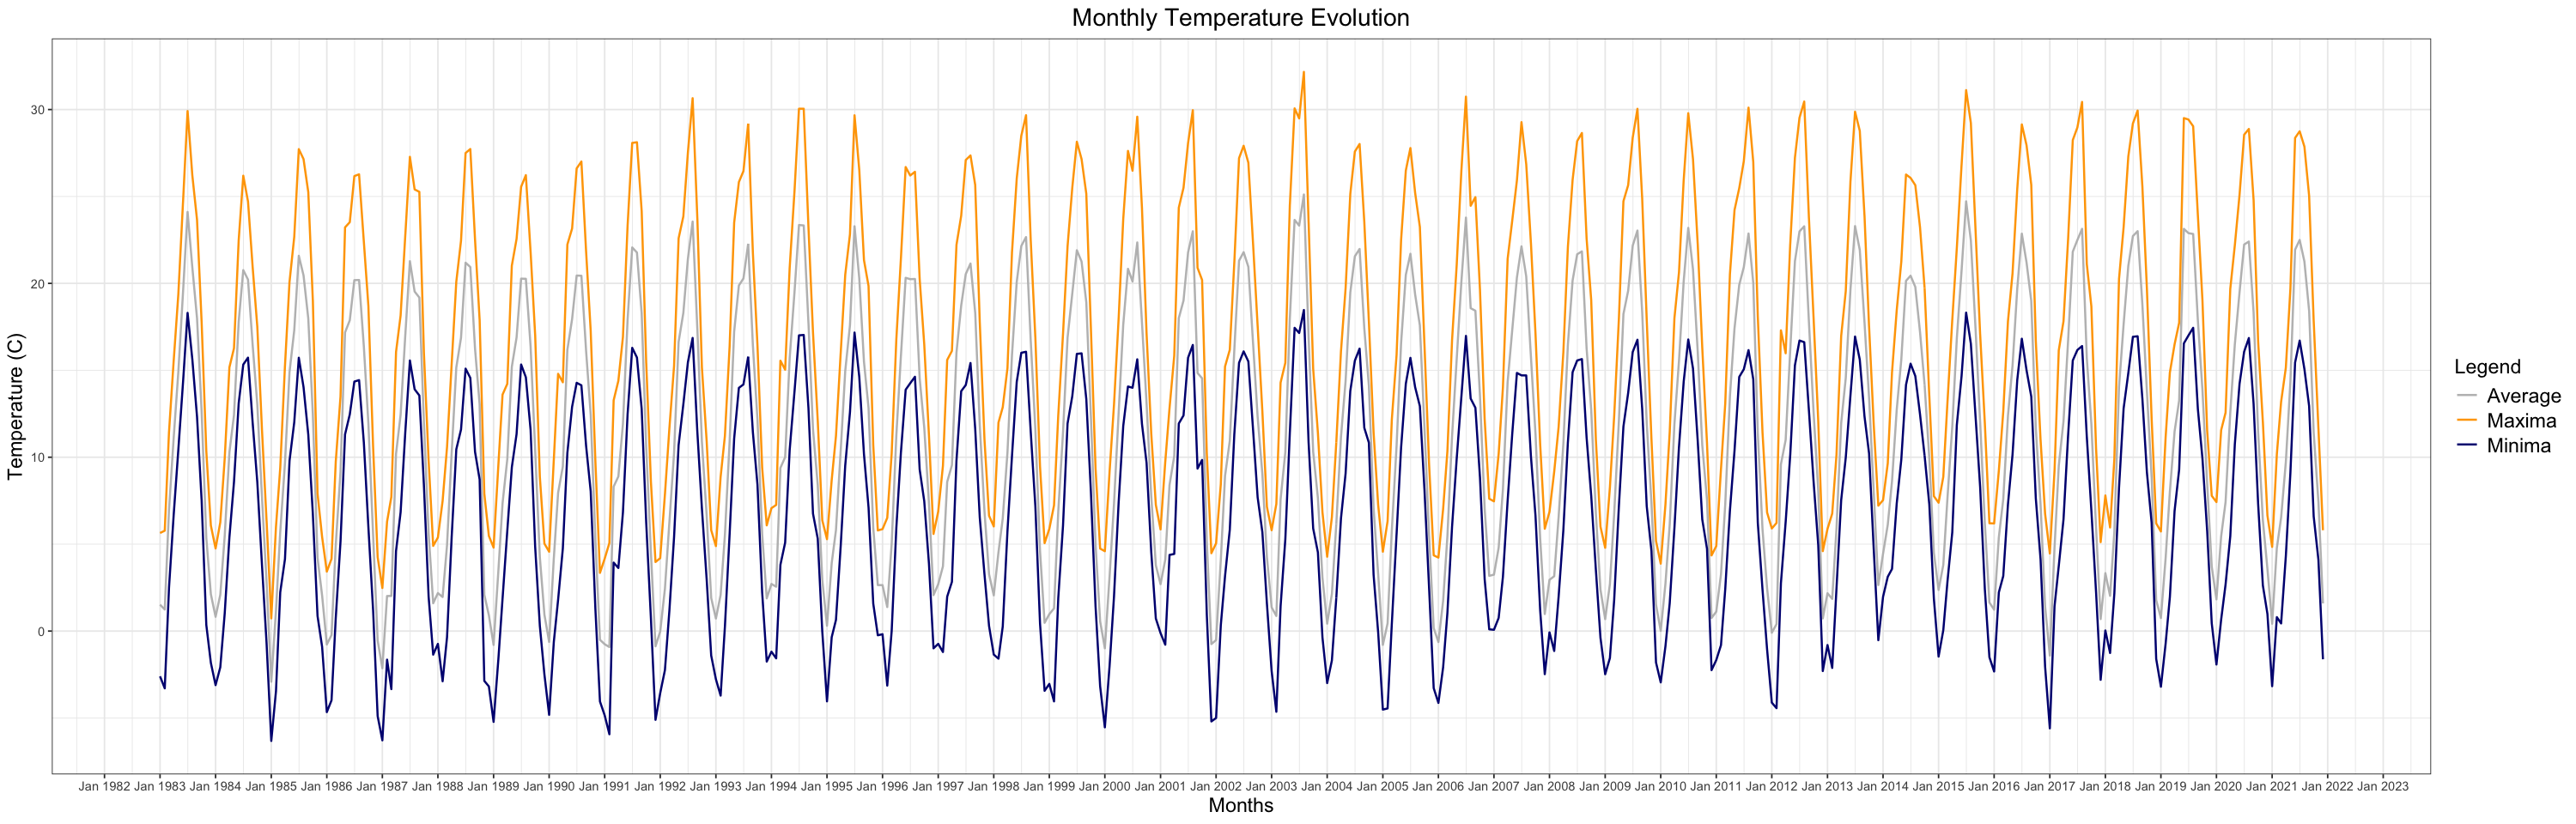

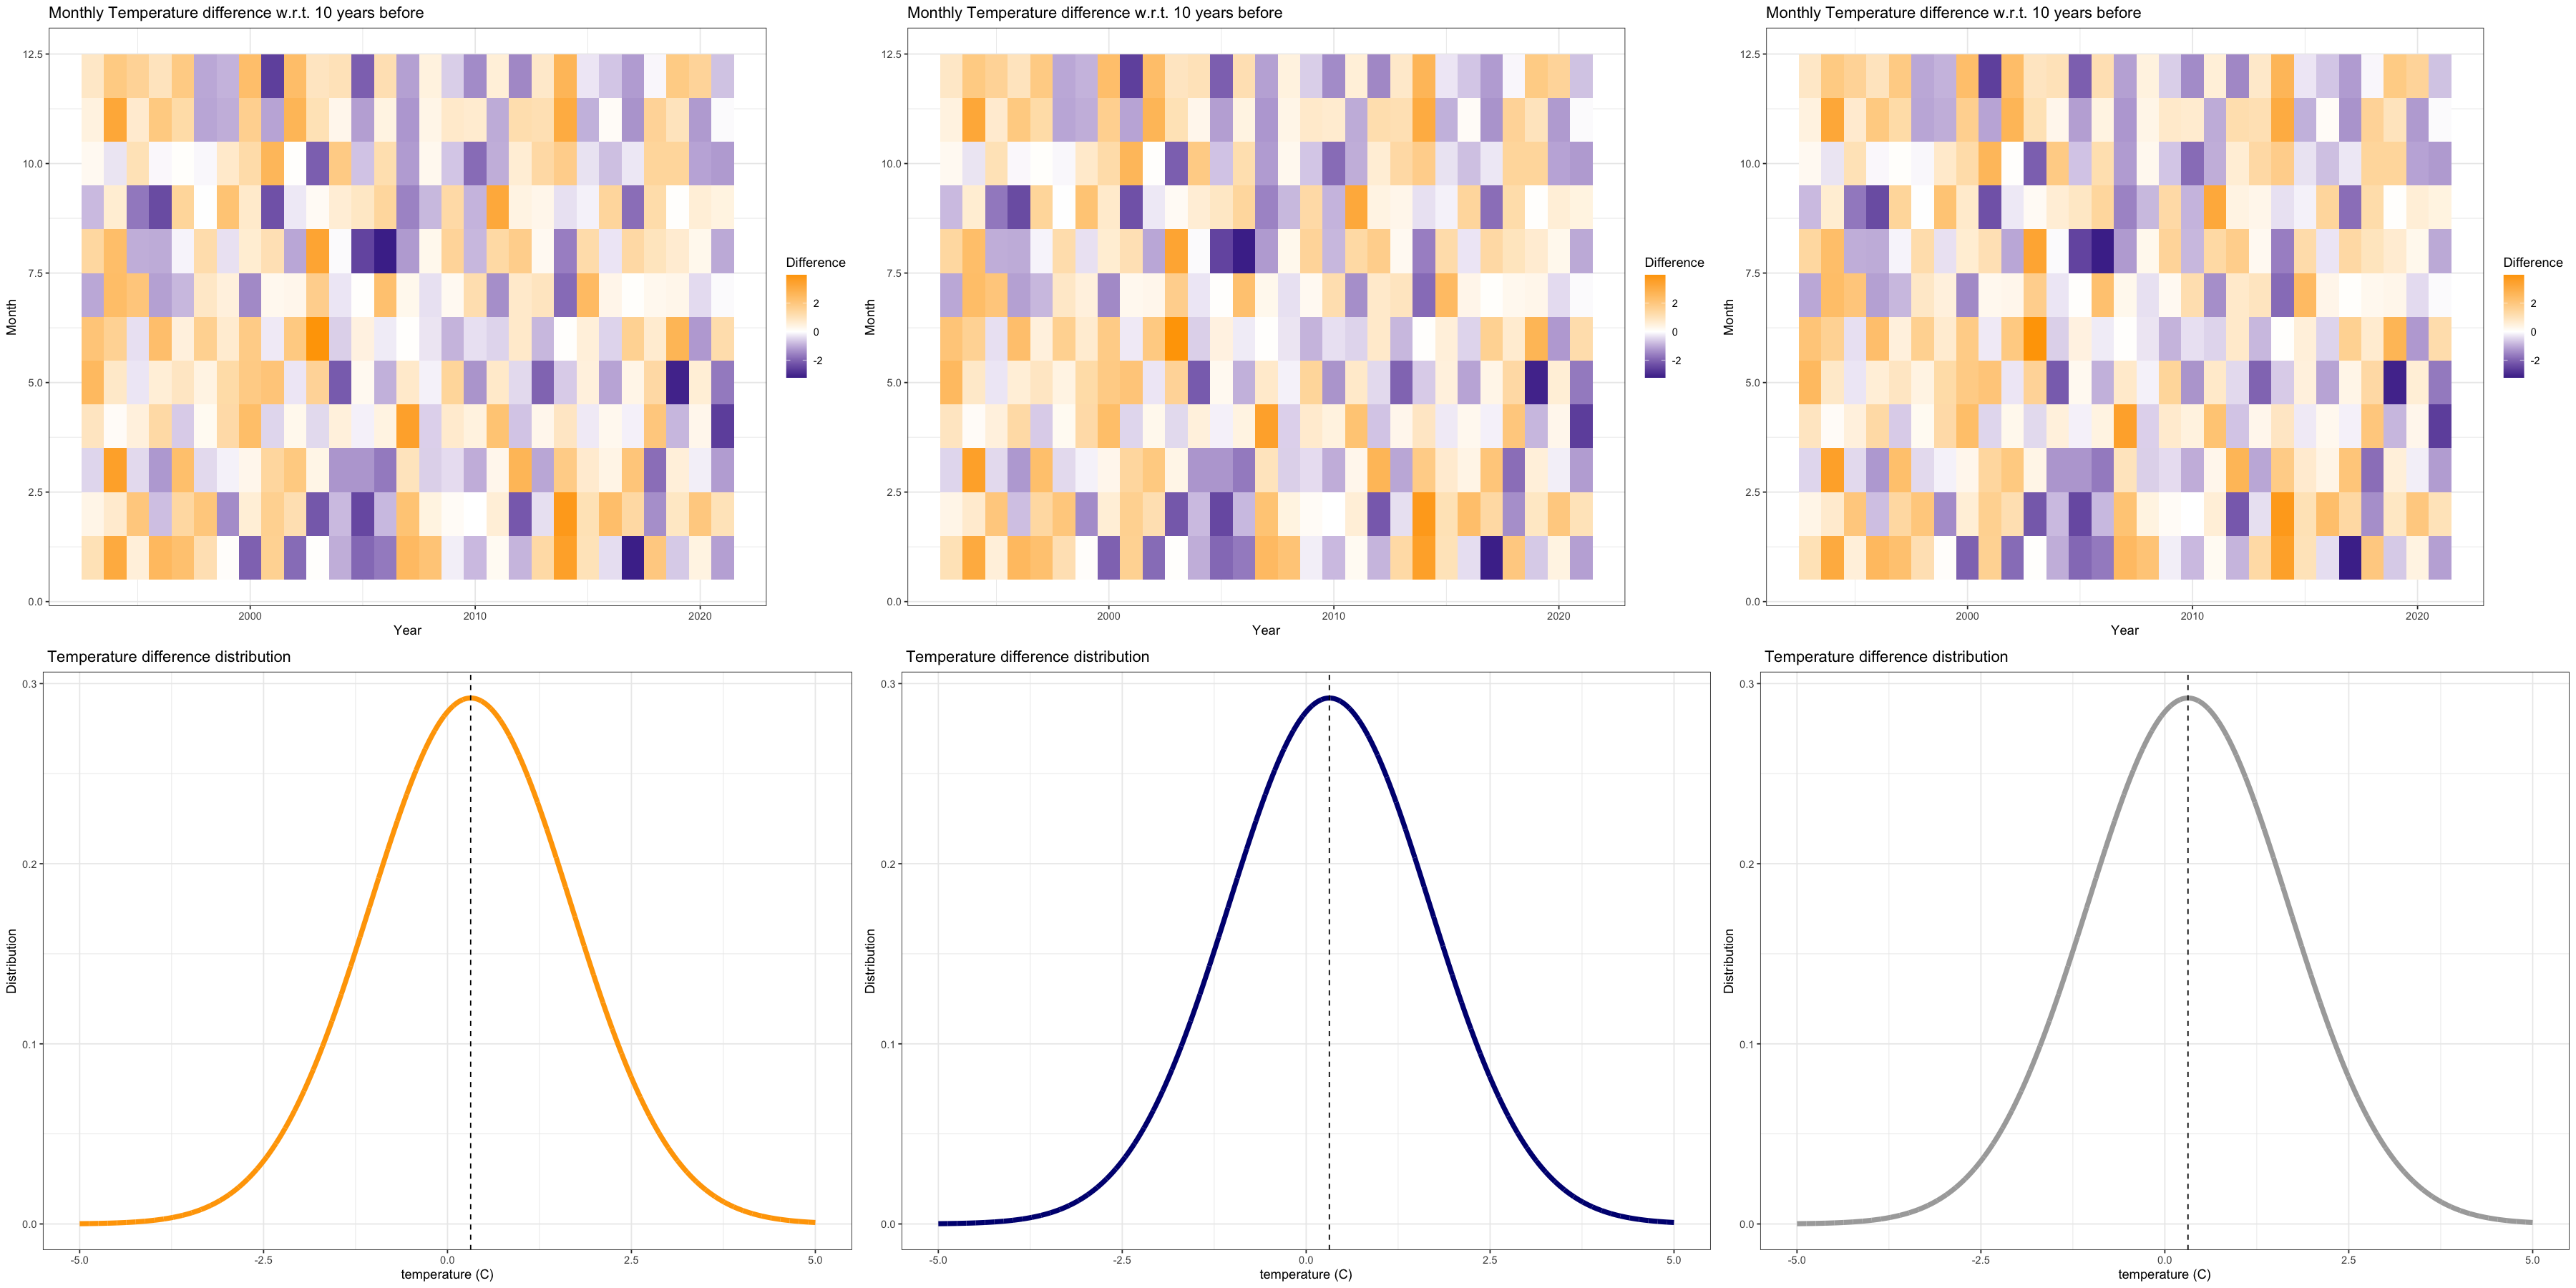

In [255]:
# Imposta la larghezza e l'altezza del plot
options(repr.plot.width = 25, repr.plot.height = 8)

# Grafico mensile
p_m <- ggplot(data = monthly_dataset) +
  geom_line(aes(x = month, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Monthly Temperature Evolution',
       x = 'Months',
       y = 'Temperature (C)') +
  scale_x_date(date_breaks = "12 month", date_labels = "%b %Y") +
  theme_bw() +
  theme(plot.title = element_text(size = 17, hjust = 0.5),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14))

# Visualizza il grafico mensile
print(p_m)

h_max <- create_heatmap(df = monthly_dataset, str = 'max')
h_max_mean <- mean(h_max[[2]]$Difference)
h_max_var <- var(h_max[[2]]$Difference)
h_min <- create_heatmap(df = monthly_dataset, str = 'min')
h_min_mean <- mean(h_min[[2]]$Difference)
h_min_var <- var(h_min[[2]]$Difference)
h_ava <- create_heatmap(df = monthly_dataset, str = 'ava')
h_ava_mean <- mean(h_ava[[2]]$Difference)
h_ava_var <- var(h_ava[[2]]$Difference)

x_axis = seq(-5,5,0.001)

max_dist = dnorm(x=x_axis,sd = sqrt(h_max_var), mean = h_max_mean)
min_dist = dnorm(x=x_axis,sd = sqrt(h_min_var), mean = h_min_mean)
ava_dist = dnorm(x=x_axis,sd = sqrt(h_ava_var), mean = h_ava_mean)
df_max <- data.frame(x = x_axis, y = max_dist)
df_min <- data.frame(x = x_axis, y = min_dist)
df_ava <- data.frame(x = x_axis, y = ava_dist)


plot_max <- ggplot(df_max, aes(x = x, y = y)) + 
  geom_line(color = 'orange', linewidth = 2) + 
  geom_vline(aes(xintercept = h_max_mean), linetype = 2) +
  theme_bw()+
  labs(title = ' Temperature difference distribution ',
       x = 'temperature (C)',
       y = 'Distribution') 

plot_min <- ggplot(df_min, aes(x = x, y = y)) + 
  geom_line(color = 'navy', linewidth = 2) + 
  geom_vline(aes(xintercept = h_min_mean), linetype = 2) +
  theme_bw()+
  labs(title = ' Temperature difference distribution ',
       x = 'temperature (C)',
       y = 'Distribution') 

plot_ava <- ggplot(df_ava, aes(x = x, y = y)) + 
  geom_line(color = 'darkgray', linewidth = 2) + 
  geom_vline(aes(xintercept = h_ava_mean), linetype = 2) +
  theme_bw()+
  labs(title = ' Temperature difference distribution ',
       x = 'temperature (C)',
       y = 'Distribution') 

options(repr.plot.width = 30, repr.plot.height = 15)
grid.arrange(h_max[[1]], h_min[[1]], h_ava[[1]], 
             plot_max, plot_min, plot_ava, 
             ncol = 3, nrow = 2)





# Part 1

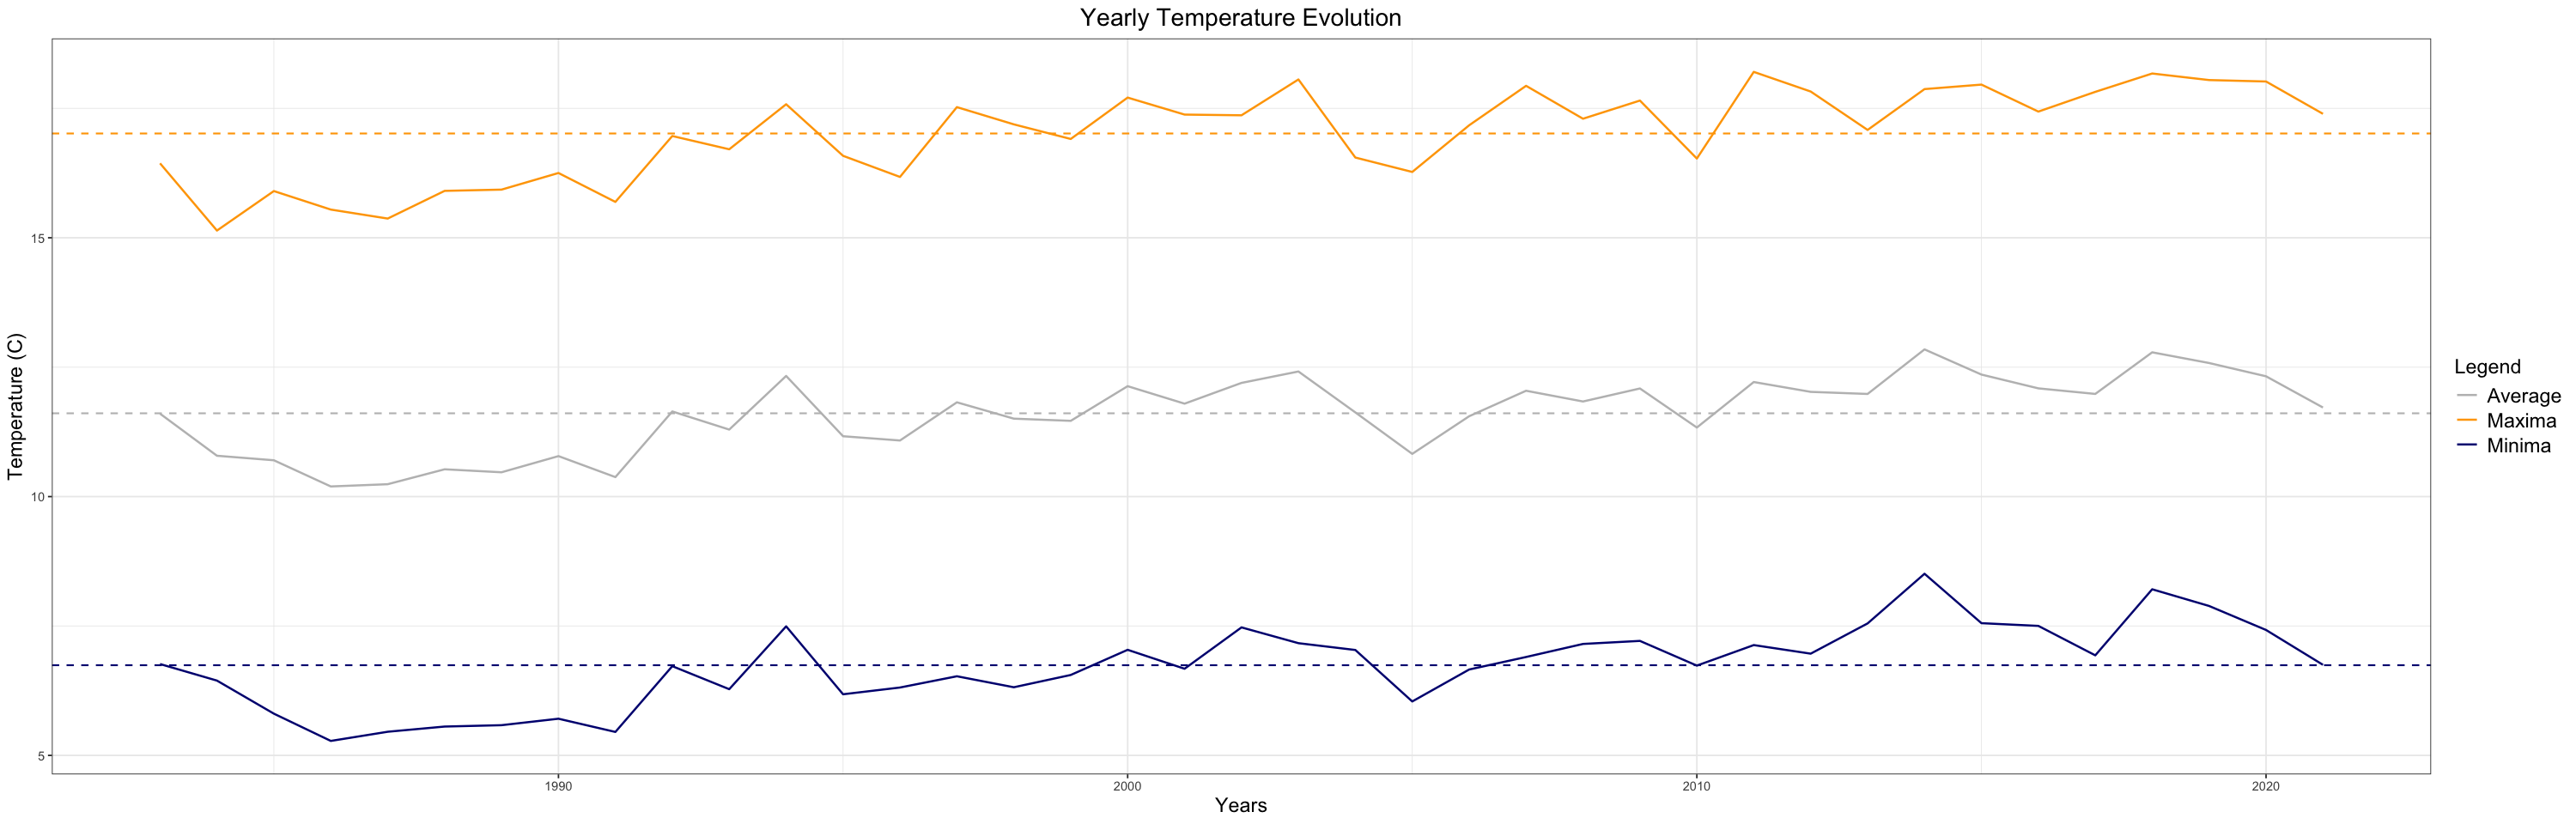

In [256]:
options(repr.plot.width = 25, repr.plot.height = 8)
# Grafico annuale
p_y <- ggplot(data = yearly_dataset) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Evolution',
       x = 'Years',
       y = 'Temperature (C)') +
  theme_bw() +
  theme(plot.title = element_text(size = 17, hjust = 0.5),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14))

# Visualizza il grafico annuale
print(p_y)

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in max(ids, na.rm = TRUE):
"nessun argomento non-mancante al massimo; si restituisce -Inf"
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."


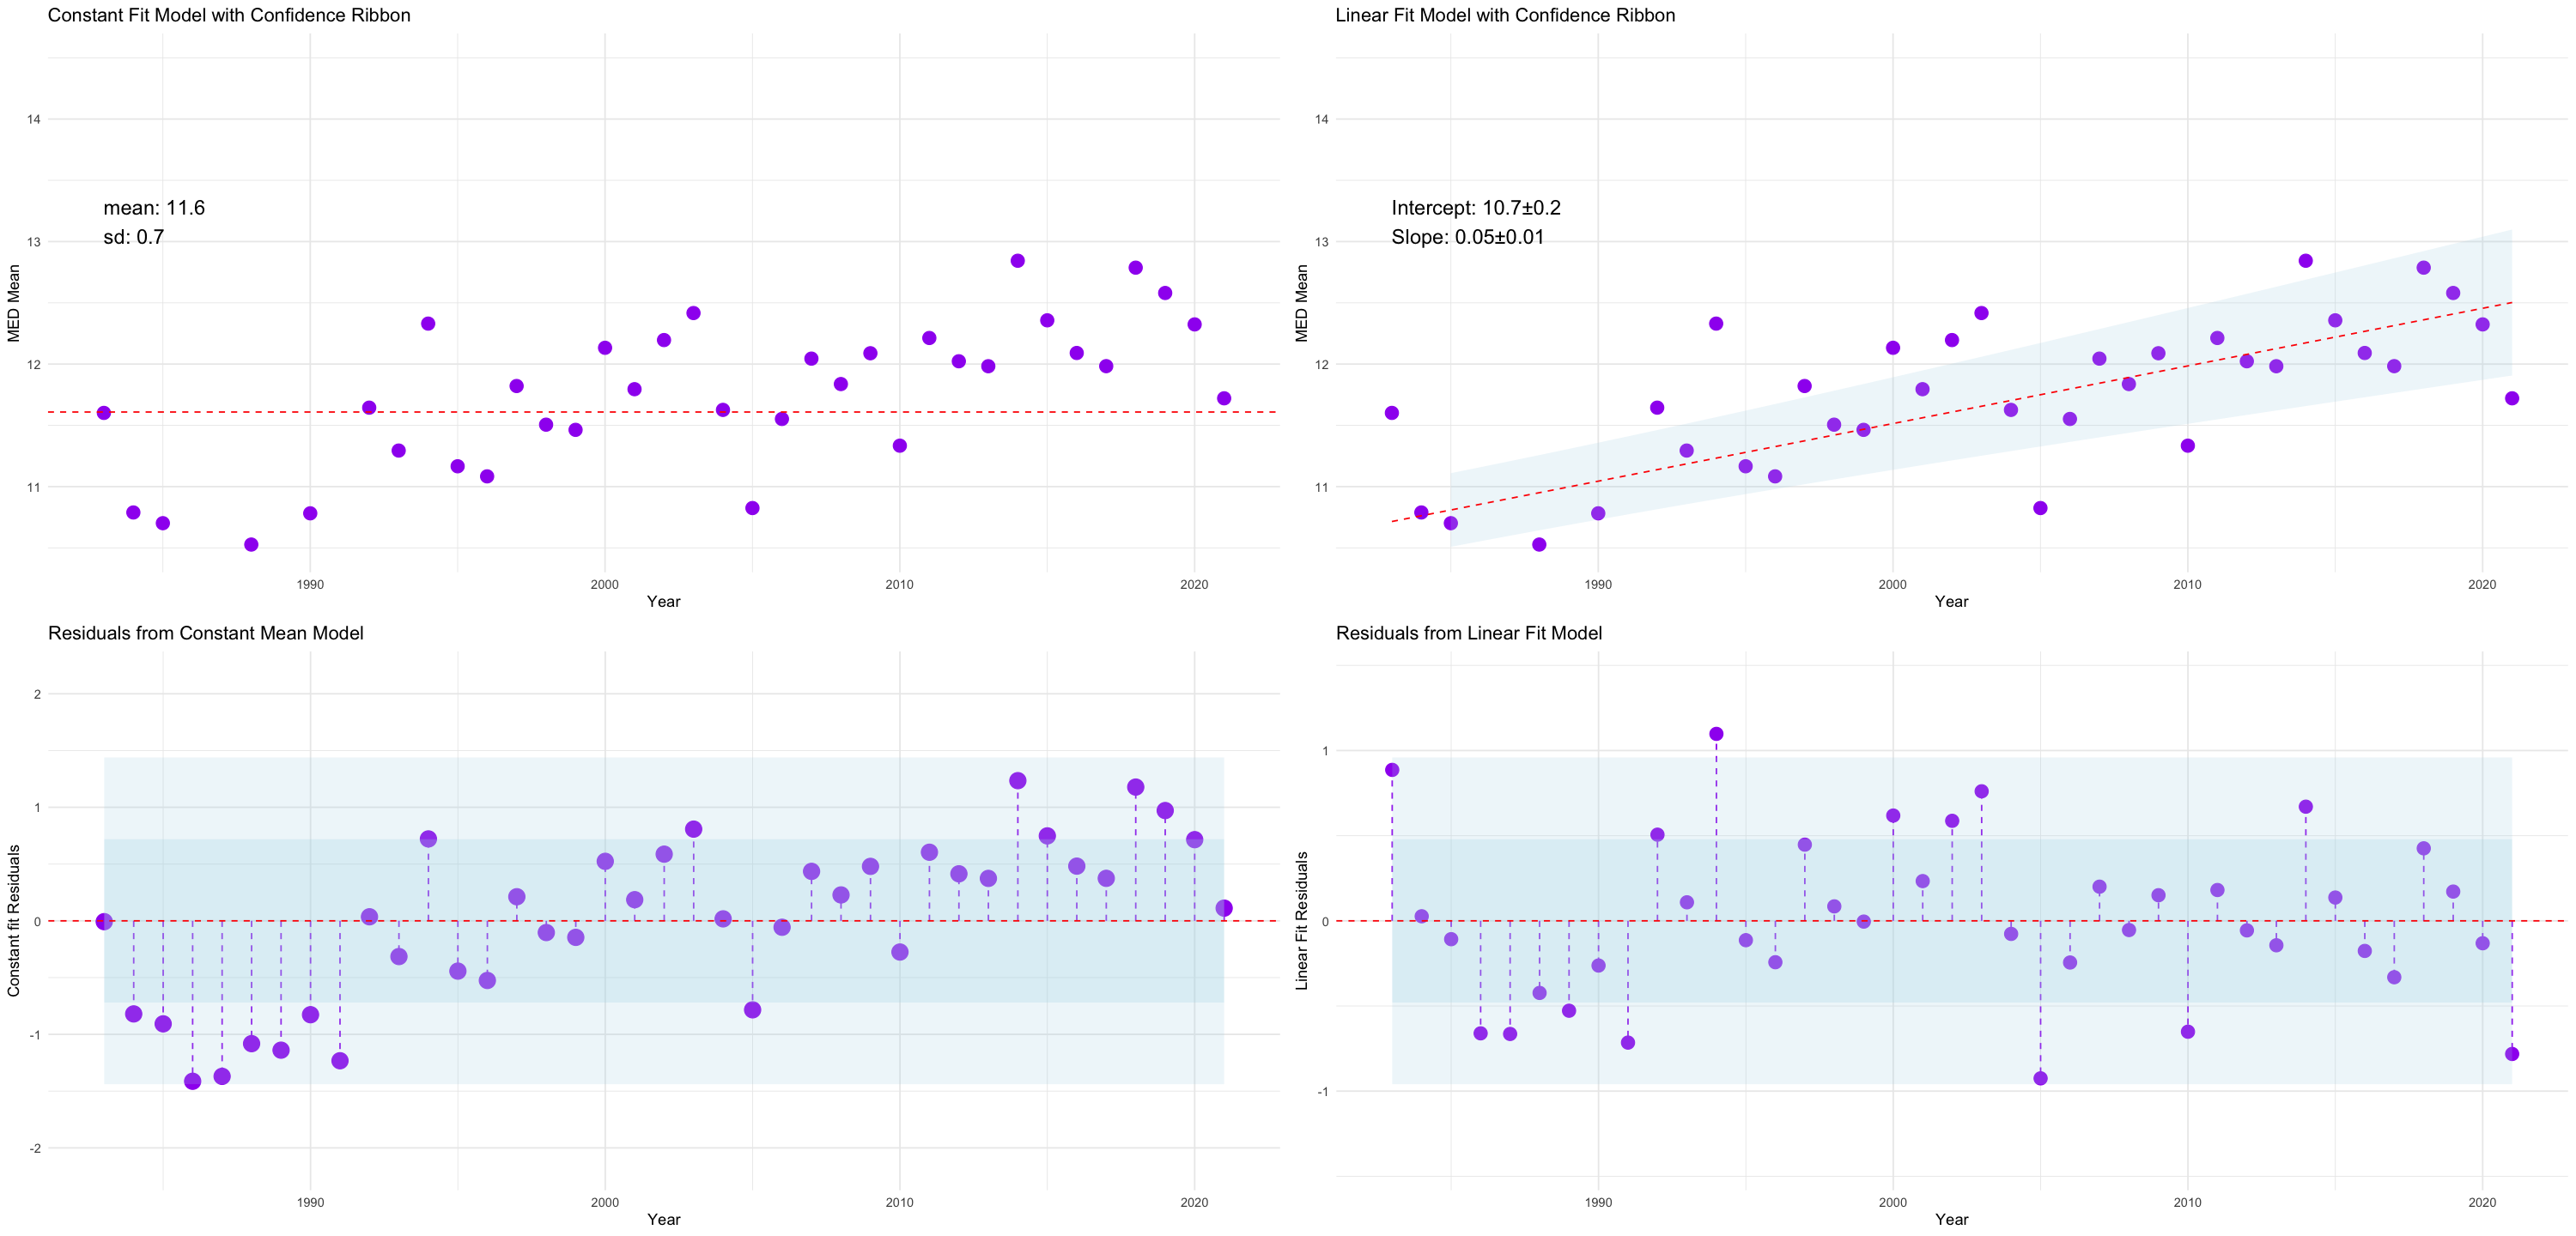

In [257]:
model <- lm(MED_mean ~ x_fit, data = yearly_dataset)
model_summary <- summary(model)
model_coeff_err <- coef(model_summary)[, "Std. Error"]
model_coeff <- coef(model_summary)[, 'Estimate']


fit_dataframe <- yearly_dataset |>
  select(year_only, MED_mean) |>
  mutate(linear_residuals = model$residuals) |>
  mutate(const_residuals = MED_mean - mean(MED_mean)) |>
  mutate(fitted_linear = model$fitted.values)

fit_dataframe <- fit_dataframe |>
  mutate(conf_lower = fitted_linear - 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2),
         conf_upper = fitted_linear + 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2)) |>
  mutate(x_fit = yearly_dataset$x_fit)


constant_fit_text <- paste0("mean: ", round(mean(yearly_dataset$MED_mean), 1), 
                            "\nsd: ", round(sqrt(var(yearly_dataset$MED_mean)), 1))


p_a <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = mean(MED_mean) - 1.96*sqrt(var(MED_mean)), 
                  ymax = mean(MED_mean) + 1.96*sqrt(var(MED_mean))), 
              alpha = 0.2, fill = 'lightblue') +
  geom_hline(aes(yintercept = mean(MED_mean)), linetype = 2, color = 'red') +
  theme_minimal() +
  ylim(10.5, 14.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.5, 
           label = constant_fit_text, hjust = 0, vjust = 1, size = 5, color = 'black') +
  labs(title = "Constant Fit Model with Confidence Ribbon",
       x = "Year",
       y = "MED Mean")


linear_fit_text <- paste0("Intercept: ", round(model_coeff[1], 1), '\u00B1', round(model_coeff_err[1], 1), 
                          "\nSlope: ", round(model_coeff[2], 2), '\u00B1', round(model_coeff_err[2], 2))

p_b <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = conf_lower, ymax = conf_upper), alpha = 0.2, fill = 'lightblue') +
  geom_line(aes(x = year_only, y = fitted_linear), linetype = 2, col = 'red') +
  theme_minimal() +
  ylim(10.5, 14.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.5, 
           label = linear_fit_text, hjust = 0, vjust = 1, size = 5, color = "black") +
  labs(title = "Linear Fit Model with Confidence Ribbon",
       x = "Year",
       y = "MED Mean")

p_c <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = const_residuals), col = 'purple', size = 5) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = const_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = 2*sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2*sqrt(var(MED_mean)), ymax = 3*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2*sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3*sqrt(var(MED_mean)), ymax = -2*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Constant Mean Model",
       x = "Year",
       y = "Constant fit Residuals")


p_d <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = linear_residuals), col = 'purple', size = 4) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = linear_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = 2 * sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2 * sqrt(var(linear_residuals)), ymax = 3 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2 * sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3 * sqrt(var(linear_residuals)), ymax = -2 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Linear Fit Model",
       x = "Year",
       y = "Linear Fit Residuals")


options(repr.plot.width = 25, repr.plot.height = 12)


grid.arrange(p_a, p_b, p_c, p_d, 
             ncol = 2, nrow = 2)


In [264]:
init_variables <- function(model_name) {
    if (model_name == "lin_model") {
        return( list(a_min = runif(1, -20, 20), b_min = runif(1, -0.5, 0.5), sigma_min = runif(1, 0, 0.8),
                     a_max = runif(1, -20, 20), b_max = runif(1, -0.5, 0.5), sigma_max = runif(1, 0, 0.8),
                     a_ava = runif(1, -20, 20), b_ava = runif(1, -0.5, 0.5), sigma_ava = runif(1, 0, 0.8)))
    } else if (model_name == "const_model") {
        return( list(a_min = runif(1, -20, 20), sigma_min = runif(1, 0, 0.8),
                     a_max = runif(1, -20, 20), sigma_max = runif(1, 0, 0.8),
                     a_ava = runif(1, -20, 20), sigma_ava = runif(1, 0, 0.8)))
    }
}

regression <- function(df, model_file, params) {
    data <- df %>% select(x_fit, MAX_mean, MIN_mean, MED_mean)
    inits <- init_variables(gsub(".jags", "", model_file))
    jm <- jags.model(model_file, data, inits, n.chains = 1, n.adapt = 1000)
    update(jm, n.iter = 50000)
    chain <- coda.samples(jm, params, n.iter = 1e6, thin = 20)
    return(chain)
}


##########################################################
# da modificare con l'introduzione delle altre temperature 
##########################################################
trace_plot <- function(chain, type) {
    chain_df <- as.data.frame( as.mcmc(chain) ) 
    chain_df$iteration <- seq.int(nrow(chain_df))
    
    if(type == 'linear'){
        
        plot_a <- ggplot(chain_df, aes(x = iteration, y = a)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of a"),
                x = "Iteration",
                y = 'a') +
            theme_minimal()

        plot_b <- ggplot(chain_df, aes(x = iteration, y = b)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of b"),
                x = "Iteration",
                y = 'b') +
            theme_minimal()
        
        plot_sigma <- ggplot(chain_df, aes(x = iteration, y = sigma)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of sigma"),
                x = "Iteration",
                y = 'sigma') +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_b, plot_sigma,  ncol = 3, nrow = 1))
    }

    else if(type == 'constant'){
       
        plot_a <- ggplot(chain_df, aes(x = iteration, y = a)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of a"),
                x = "Iteration",
                y = 'a') +
            theme_minimal()

        
        plot_sigma <- ggplot(chain_df, aes(x = iteration, y = sigma)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of sigma"),
                x = "Iteration",
                y = 'sigma') +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_sigma,  ncol = 2, nrow = 1))
    }    
}

# modificato bene 
density_plot <- function(chain, type, temp) {
    chain_df <- as.data.frame( as.mcmc(chain) ) 
    quantiles <- summary(chain)$quantiles[,c('2.5%','97.5%')]

    if(temp == 'min'){
        if(type == 'linear'){

            lower_a = quantiles['a_min','2.5%']
            upper_a = quantiles['a_min','97.5%']
            plot_a <- ggplot(chain_df, aes(x = a_min)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = mean(a_min)), linetype = 2)+
                geom_vline(aes(xintercept = lower_a), color = 'red')+
                geom_vline(aes(xintercept = upper_a), color = 'red')+
                labs(title = paste("Posterior Distribution of a"),
                    x = 'a',
                    y = "Density") +
                theme_minimal()
    
            lower_b = quantiles['b_min','2.5%']
            upper_b = quantiles['b_min','97.5%']
            plot_b <- ggplot(chain_df, aes(x = b_min)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_b), color = 'red')+
                geom_vline(aes(xintercept = upper_b), color = 'red')+
                geom_vline(aes(xintercept =mean(b_min)), linetype = 2)+
                labs(title = paste("Posterior Distribution of b"),
                    x = 'b',
                    y = "Density") +
                theme_minimal()
            
            lower_sigma = quantiles['sigma_min','2.5%']
            upper_sigma = quantiles['sigma_min','97.5%']
            plot_sigma <- ggplot(chain_df, aes(x = sigma_min)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_sigma), color = 'red')+
                geom_vline(aes(xintercept = upper_sigma), color = 'red')+
                geom_vline(aes(xintercept =mean(sigma_min)), linetype = 2)+
                labs(title = paste("Posterior Distribution of sigma"),
                    x = 'sigma',
                    y = "Density") +
                theme_minimal()
            options(repr.plot.width = 25, repr.plot.height = 7)
            return(grid.arrange(plot_a, plot_b, plot_sigma,  ncol = 3, nrow = 1))
        }
    
        else if(type == 'constant'){
        
            lower_a = quantiles['a_min','2.5%']
            upper_a = quantiles['a_min','97.5%']
            plot_a <- ggplot(chain_df, aes(x = a_min)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_a), color = 'red')+
                geom_vline(aes(xintercept = upper_a), color = 'red')+
                geom_vline(aes(xintercept =mean(a_min)), linetype = 2)+
                labs(title = paste("Posterior Distribution of a"),
                    x = 'a',
                    y = "Density") +
                theme_minimal()
    
            lower_sigma = quantiles['sigma_min','2.5%']
            upper_sigma = quantiles['sigma_min','97.5%']
            plot_sigma <- ggplot(chain_df, aes(x = sigma_min)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_sigma), color = 'red')+
                geom_vline(aes(xintercept = upper_sigma), color = 'red')+
                geom_vline(aes(xintercept =mean(sigma_min)), linetype = 2)+
                labs(title = paste("Posterior Distribution of sigma"),
                    x = 'sigma',
                    y = "Density") +
                theme_minimal()
            options(repr.plot.width = 25, repr.plot.height = 7)
            return(grid.arrange(plot_a, plot_sigma,  ncol = 2, nrow = 1))
        }    
    }
    else if(temp == 'max'){
        if(type == 'linear'){

            lower_a = quantiles['a_max','2.5%']
            upper_a = quantiles['a_max','97.5%']
            plot_a <- ggplot(chain_df, aes(x = a_max)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = mean(a_max)), linetype = 2)+
                geom_vline(aes(xintercept = lower_a), color = 'red')+
                geom_vline(aes(xintercept = upper_a), color = 'red')+
                labs(title = paste("Posterior Distribution of a"),
                    x = 'a',
                    y = "Density") +
                theme_minimal()
    
            lower_b = quantiles['b_max','2.5%']
            upper_b = quantiles['b_max','97.5%']
            plot_b <- ggplot(chain_df, aes(x = b_max)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_b), color = 'red')+
                geom_vline(aes(xintercept = upper_b), color = 'red')+
                geom_vline(aes(xintercept =mean(b_max)), linetype = 2)+
                labs(title = paste("Posterior Distribution of b"),
                    x = 'b',
                    y = "Density") +
                theme_minimal()
            
            lower_sigma = quantiles['sigma_max','2.5%']
            upper_sigma = quantiles['sigma_max','97.5%']
            plot_sigma <- ggplot(chain_df, aes(x = sigma_max)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_sigma), color = 'red')+
                geom_vline(aes(xintercept = upper_sigma), color = 'red')+
                geom_vline(aes(xintercept =mean(sigma_max)), linetype = 2)+
                labs(title = paste("Posterior Distribution of sigma"),
                    x = 'sigma',
                    y = "Density") +
                theme_minimal()
            options(repr.plot.width = 25, repr.plot.height = 7)
            return(grid.arrange(plot_a, plot_b, plot_sigma,  ncol = 3, nrow = 1))
        }
    
        else if(type == 'constant'){
        
            lower_a = quantiles['a_max','2.5%']
            upper_a = quantiles['a_max','97.5%']
            plot_a <- ggplot(chain_df, aes(x = a_max)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_a), color = 'red')+
                geom_vline(aes(xintercept = upper_a), color = 'red')+
                geom_vline(aes(xintercept =mean(a_max)), linetype = 2)+
                labs(title = paste("Posterior Distribution of a"),
                    x = 'a',
                    y = "Density") +
                theme_minimal()
    
            lower_sigma = quantiles['sigma_max','2.5%']
            upper_sigma = quantiles['sigma_max','97.5%']
            plot_sigma <- ggplot(chain_df, aes(x = sigma_max)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_sigma), color = 'red')+
                geom_vline(aes(xintercept = upper_sigma), color = 'red')+
                geom_vline(aes(xintercept =mean(sigma_max)), linetype = 2)+
                labs(title = paste("Posterior Distribution of sigma"),
                    x = 'sigma',
                    y = "Density") +
                theme_minimal()
            options(repr.plot.width = 25, repr.plot.height = 7)
            return(grid.arrange(plot_a, plot_sigma,  ncol = 2, nrow = 1))
        }  
    }
    else if(temp == 'ava'){
        if(type == 'linear'){

            lower_a = quantiles['a_ava','2.5%']
            upper_a = quantiles['a_ava','97.5%']
            plot_a <- ggplot(chain_df, aes(x = a_ava)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = mean(a_ava)), linetype = 2)+
                geom_vline(aes(xintercept = lower_a), color = 'red')+
                geom_vline(aes(xintercept = upper_a), color = 'red')+
                labs(title = paste("Posterior Distribution of a"),
                    x = 'a',
                    y = "Density") +
                theme_minimal()
    
            lower_b = quantiles['b_ava','2.5%']
            upper_b = quantiles['b_ava','97.5%']
            plot_b <- ggplot(chain_df, aes(x = b_ava)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_b), color = 'red')+
                geom_vline(aes(xintercept = upper_b), color = 'red')+
                geom_vline(aes(xintercept =mean(b_ava)), linetype = 2)+
                labs(title = paste("Posterior Distribution of b"),
                    x = 'b',
                    y = "Density") +
                theme_minimal()
            
            lower_sigma = quantiles['sigma_ava','2.5%']
            upper_sigma = quantiles['sigma_ava','97.5%']
            plot_sigma <- ggplot(chain_df, aes(x = sigma_ava)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_sigma), color = 'red')+
                geom_vline(aes(xintercept = upper_sigma), color = 'red')+
                geom_vline(aes(xintercept =mean(sigma_ava)), linetype = 2)+
                labs(title = paste("Posterior Distribution of sigma"),
                    x = 'sigma',
                    y = "Density") +
                theme_minimal()
            options(repr.plot.width = 25, repr.plot.height = 7)
            return(grid.arrange(plot_a, plot_b, plot_sigma,  ncol = 3, nrow = 1))
        }
    
        else if(type == 'constant'){
        
            lower_a = quantiles['a_ava','2.5%']
            upper_a = quantiles['a_ava','97.5%']
            plot_a <- ggplot(chain_df, aes(x = a_ava)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_a), color = 'red')+
                geom_vline(aes(xintercept = upper_a), color = 'red')+
                geom_vline(aes(xintercept =mean(a_ava)), linetype = 2)+
                labs(title = paste("Posterior Distribution of a"),
                    x = 'a',
                    y = "Density") +
                theme_minimal()
    
            lower_sigma = quantiles['sigma_ava','2.5%']
            upper_sigma = quantiles['sigma_ava','97.5%']
            plot_sigma <- ggplot(chain_df, aes(x = sigma_ava)) +
                geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
                geom_vline(aes(xintercept = lower_sigma), color = 'red')+
                geom_vline(aes(xintercept = upper_sigma), color = 'red')+
                geom_vline(aes(xintercept =mean(sigma_ava)), linetype = 2)+
                labs(title = paste("Posterior Distribution of sigma"),
                    x = 'sigma',
                    y = "Density") +
                theme_minimal()
            options(repr.plot.width = 25, repr.plot.height = 7)
            return(grid.arrange(plot_a, plot_sigma,  ncol = 2, nrow = 1))
        }  
    }
}

get_model_parameters <- function(chain, type, temp) {
    if(temp == 'min'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_min), b = mean(chain_df$b_min), sigma = mean(chain_df$sigma_min),
                               sd_a = sd(chain_df$a_min), sd_b = sd(chain_df$b_min), sd_sigma= sd(chain_df$sigma_min) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_min), sigma = mean(chain_df$sigma_min),
                               sd_a = sd(chain_df$a_min),  sd_sigma= sd(chain_df$sigma_min) ) 
            return(parameters)
        }
    }
    else if(temp == 'max'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_max), b = mean(chain_df$b_max), sigma = mean(chain_df$sigma_max),
                               sd_a = sd(chain_df$a_max), sd_b = sd(chain_df$b_max), sd_sigma= sd(chain_df$sigma_max) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_max), sigma = mean(chain_df$sigma_max),
                               sd_a = sd(chain_df$a_max),  sd_sigma= sd(chain_df$sigma_max) ) 
            return(parameters)
        }
    }
    else if(temp == 'ava'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_ava), b = mean(chain_df$b_ava), sigma = mean(chain_df$sigma_ava),
                               sd_a = sd(chain_df$a_ava), sd_b = sd(chain_df$b_ava), sd_sigma= sd(chain_df$sigma_ava) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_ava), sigma = mean(chain_df$sigma_ava),
                               sd_a = sd(chain_df$a_ava),  sd_sigma= sd(chain_df$sigma_ava) ) 
            return(parameters)
        }
    }        
}

get_model_prediction <- function(chain, dataset, type, temp){

    if(type == 'linear'){
        parameters <- get_model_parameters(chain,type = 'linear', temp)
        y_pred <- parameters$a + (parameters$b * dataset$x_fit)        
    }
    else if(type == 'constant'){
        parameters <- get_model_parameters(chain,type = 'constant', temp)
        y_pred <- parameters$a
    }
    return(y_pred)
}

get_model_likelihood <- function(chain, dataset, type, temp){
    param <- get_model_parameters(chain, type, temp)
    pred <- get_model_prediction(chain, dataset, type, temp)
    if(temp == 'min'){
        obs <- dataset$MIN_mean
    }
    else if(temp == 'max'){
        obs <- dataset$MAX_mean
    }
    else if(temp == 'ava'){
        obs <- dataset$MED_mean
    }
    return(-1/(2* param$sigma^2) * sum((obs-pred)^2))

}


In [265]:
# Parametri per i modelli
lin_model_file <- "lin_model.jags"
lin_pars <- c("a_min", "b_min", "sigma_min", "a_max", "b_max", "sigma_max", "a_ava", "b_ava", "sigma_ava")

const_model_file <- "const_model.jags"
const_pars <- c("a_min", "sigma_min", "a_max", "sigma_max", "a_ava", "sigma_ava")

In [260]:
lin_chain <- regression(yearly_dataset, lin_model_file, lin_pars)
const_chain <- regression(yearly_dataset, const_model_file, const_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 117
   Unobserved stochastic nodes: 9
   Total graph size: 412

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 117
   Unobserved stochastic nodes: 6
   Total graph size: 173

Initializing model



$a
[1] 10.71714

$b
[1] 0.04697947

$sigma
[1] 0.5039234

$sd_a
[1] 0.1589126

$sd_b
[1] 0.007209817

$sd_sigma
[1] 0.06160926

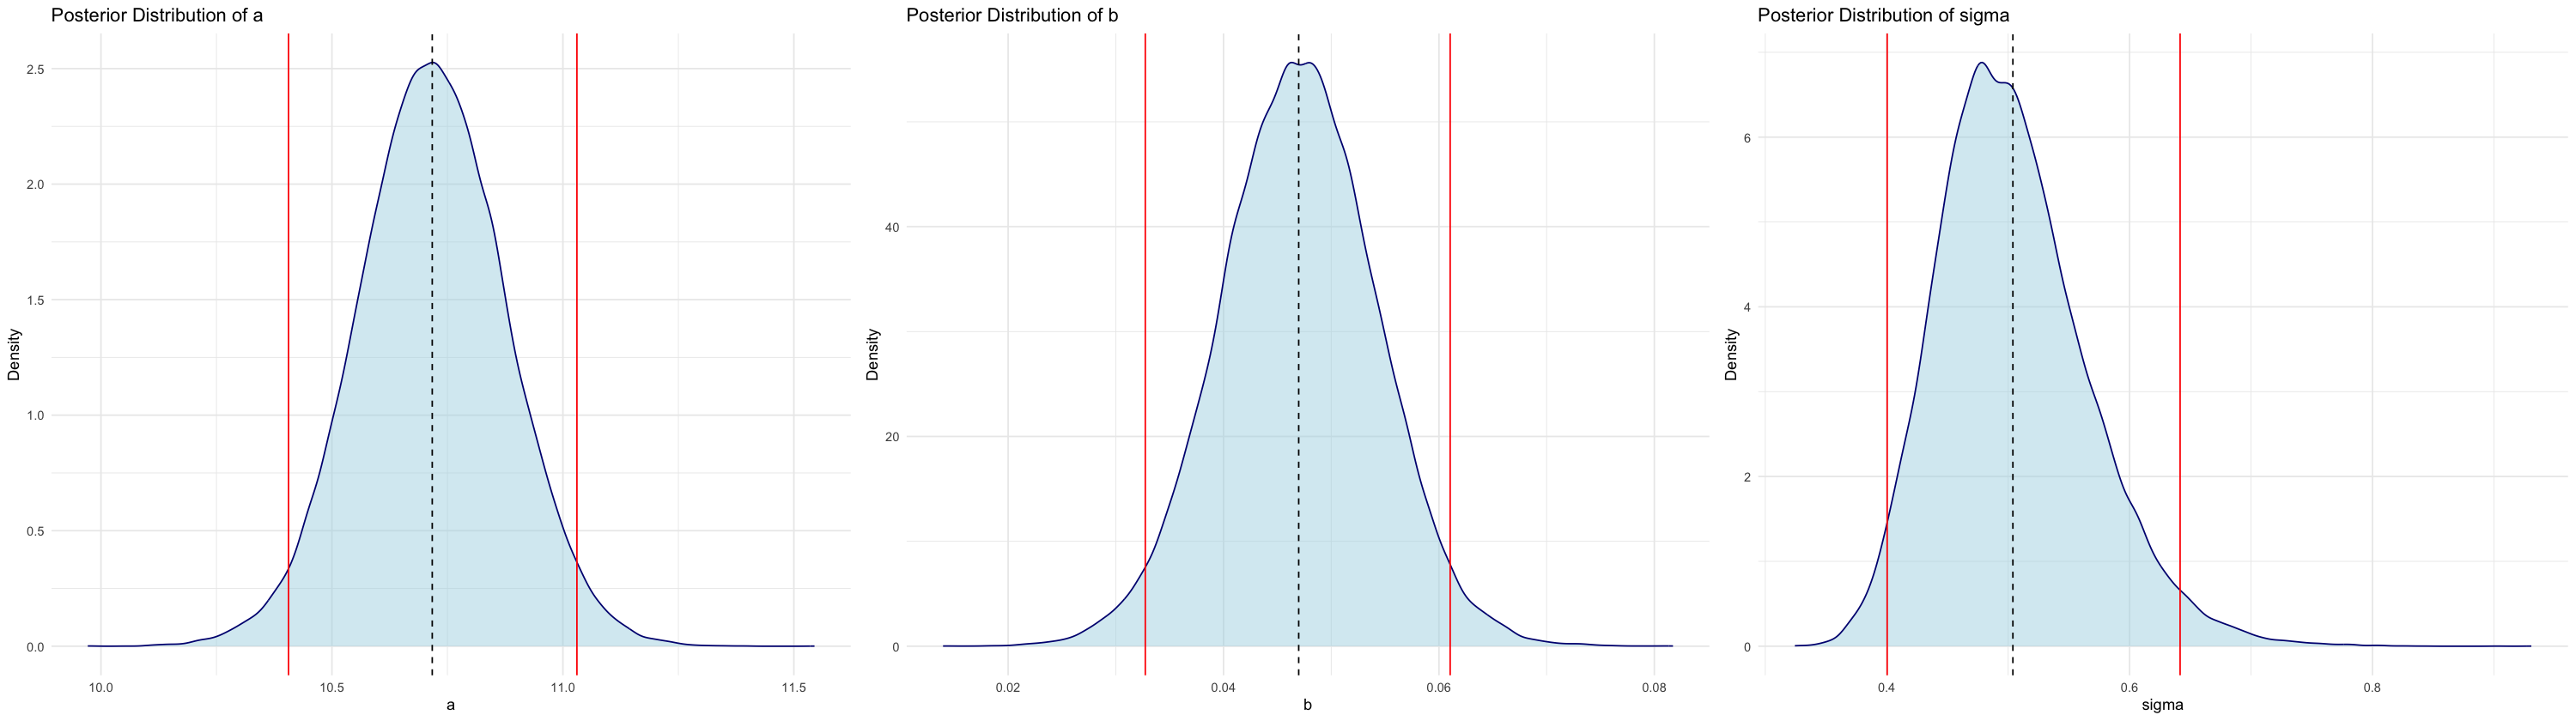

In [261]:
density_plot(lin_chain, 'linear', 'ava')
get_model_parameters(lin_chain, 'linear', 'ava')

[1] -17.21242
[1] -17.71415
Statistica del test (D): 1.003453 
Gradi di libert<U+00E0> (df): 1 
p-value: 0.3164763 


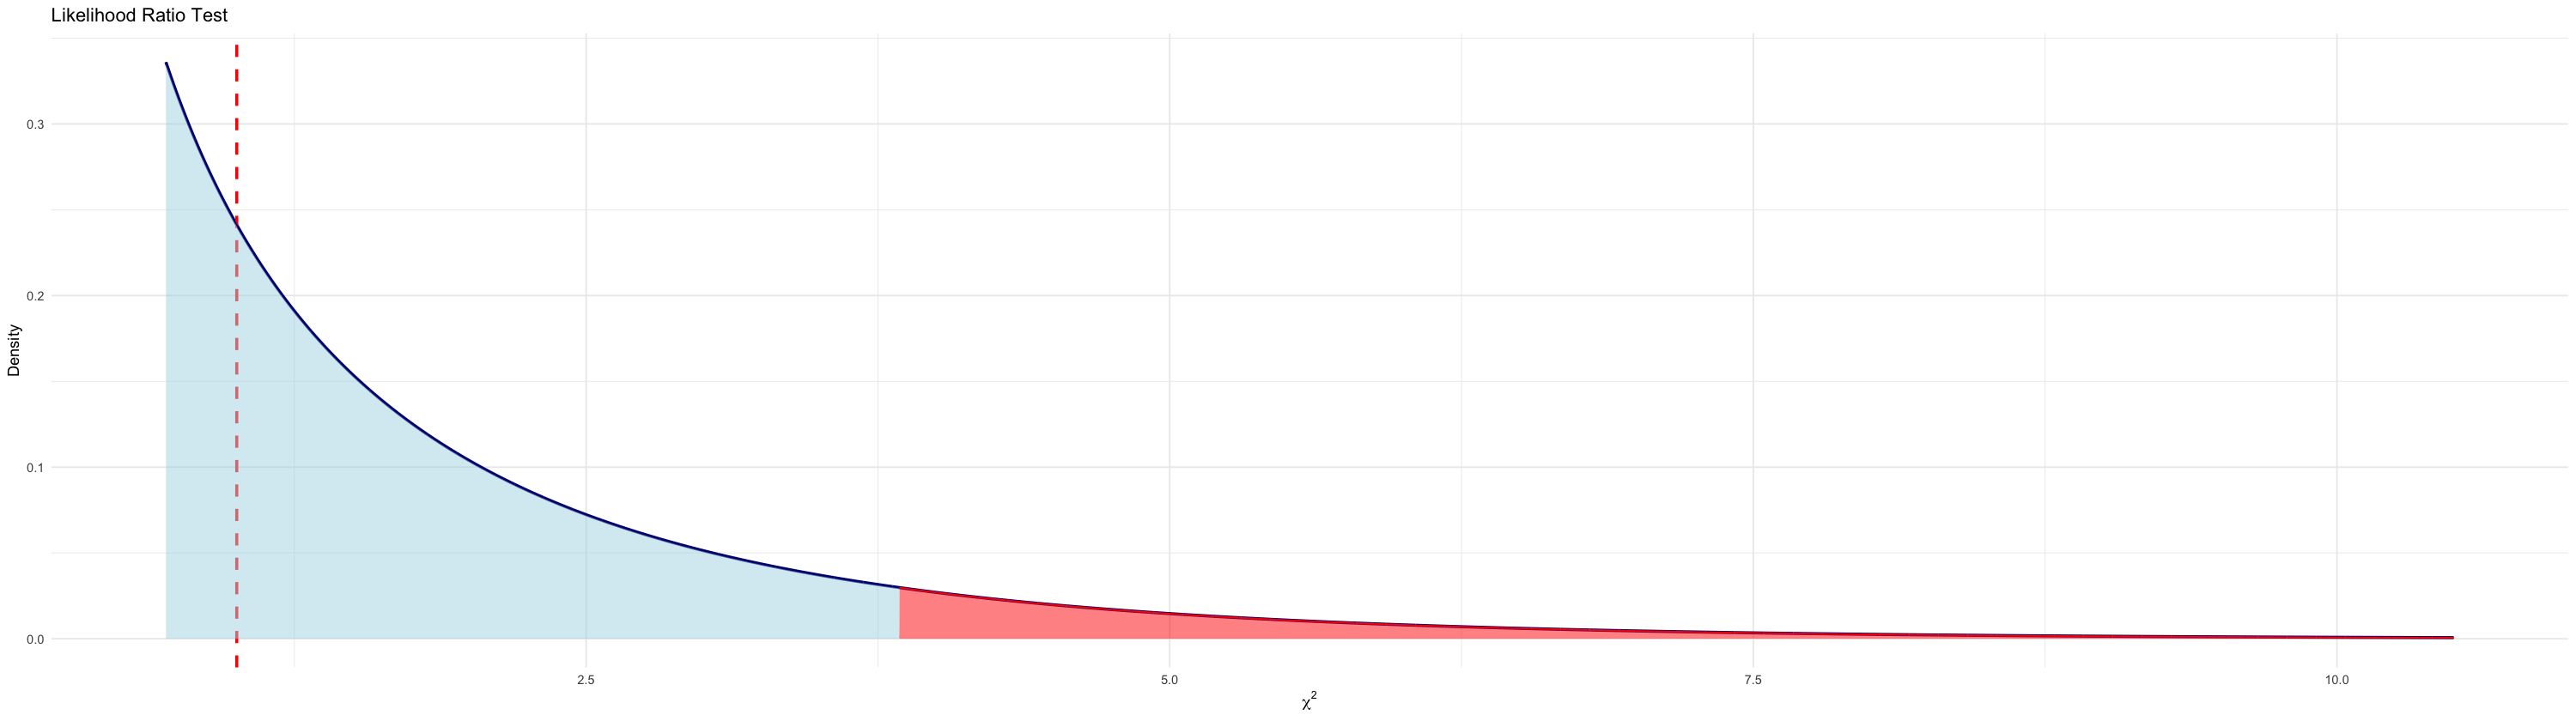

In [266]:
linear_likelihood <- get_model_likelihood(lin_chain, yearly_dataset, type = 'linear',temp = 'ava')
constant_likelihood <- get_model_likelihood(const_chain, yearly_dataset, type = 'constant', temp = 'ava')
print(linear_likelihood )
print(constant_likelihood )


log_likelihood_ratio <- - 2 * (constant_likelihood - linear_likelihood)
degree_freedom <- 1
p_value <- pchisq(log_likelihood_ratio, df = degree_freedom, lower.tail = FALSE)



cat("Statistica del test (D):", log_likelihood_ratio, "\n")
cat("Gradi di libertà (df):", degree_freedom, "\n")
cat("p-value:", p_value, "\n")


x <- seq(0.7, 10.5, length.out = 10000)
y <- dchisq(x, degree_freedom)
chi_95 <- qchisq(0.95, df = degree_freedom)

data <- data.frame(x = x, y = y)

ggplot(data, aes(x = x, y = y)) +
  geom_line(color = "navy", size = 1) +
  geom_vline(xintercept = log_likelihood_ratio, color = "red", linetype = 2, size = 1) +
  geom_area(data = subset(data, x >= chi_95), aes(x = x, y = y), fill = "red", alpha = 0.5, color = 'red') +
  geom_area(data = subset(data, x <= chi_95), aes(x = x, y = y), fill = "lightblue", alpha = 0.5, color = 'navy') +
  labs(title = "Likelihood Ratio Test",
       x = expression(chi^2),
       y = "Density") +

  theme_minimal()

In [267]:

city_dataset <- daily_dataset |>
  group_by(year_only, file) |>
  summarise(MIN_mean = mean(TMIN, na.rm = TRUE),
            MED_mean = mean(TMED, na.rm = TRUE),
            MAX_mean = mean(TMAX, na.rm = TRUE))


porto_tolle <- city_dataset |> filter(file == '101_Porto Tolle - Pradon_Temperatura aria a 2m')
auronzo <- city_dataset |> filter(file == '53_Auronzo_Temperatura aria a 2m')


corr_df <- data.frame(porto_tolle, auronzo)

# Opzioni per la dimensione del plot
options(repr.plot.width = 12, repr.plot.height = 7)


ggplot(city_dataset, aes(x = MIN_mean, y = MAX_mean, color = file)) +
  geom_point(size = 3) +
  labs(
    title = "Scatter Plot delle Temperature Minime Medie vs Massime Medie per Stazione",
    x = "Temperatura Minima Media (°C)",
    y = "Temperatura Massima Media (°C)",
    color = "Stazione"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )


correlation_pearson <- cor(porto_tolle$MED_mean, auronzo$MED_mean, method = "pearson")
ggplot(corr_df, aes(x = MED_mean, y = MED_mean.1)) +
  geom_point(size = 3, color = 'navy') +
  labs(
    title = "Parity Plot delle Temperature Medie tra Porto Tolle e Auronzo",
    x = "Temperatura Media Porto Tolle (°C)",
    y = "Temperatura Media Auronzo (°C)"
  ) +
  theme_minimal() +
  annotate("text", x = 12.7 , y =7.7, 
           label = paste("Correlazione Pearson: ", round(correlation_pearson, 2)), 
           hjust = 0, vjust = 1, size = 5, color = "black") 

`summarise()` has grouped output by 'year_only'. You can override using the
`.groups` argument.


ERROR: Error in data.frame(porto_tolle, auronzo): gli argomenti implicano un numero differente di righe: 33, 38


# Part 2

year_only,MIN_mean,MED_mean,MAX_mean,x_fit
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1993,6.279188,11.29433,16.70935,1
1997,6.528919,11.82113,17.52378,2
2001,6.674016,11.79522,17.37981,3
2005,6.042278,10.82510,16.27128,4
2009,7.212099,12.08863,17.65046,5
2013,7.549836,11.98275,17.08315,6
2017,6.933232,11.98327,17.81874,7
2021,6.750020,11.72077,17.39425,8


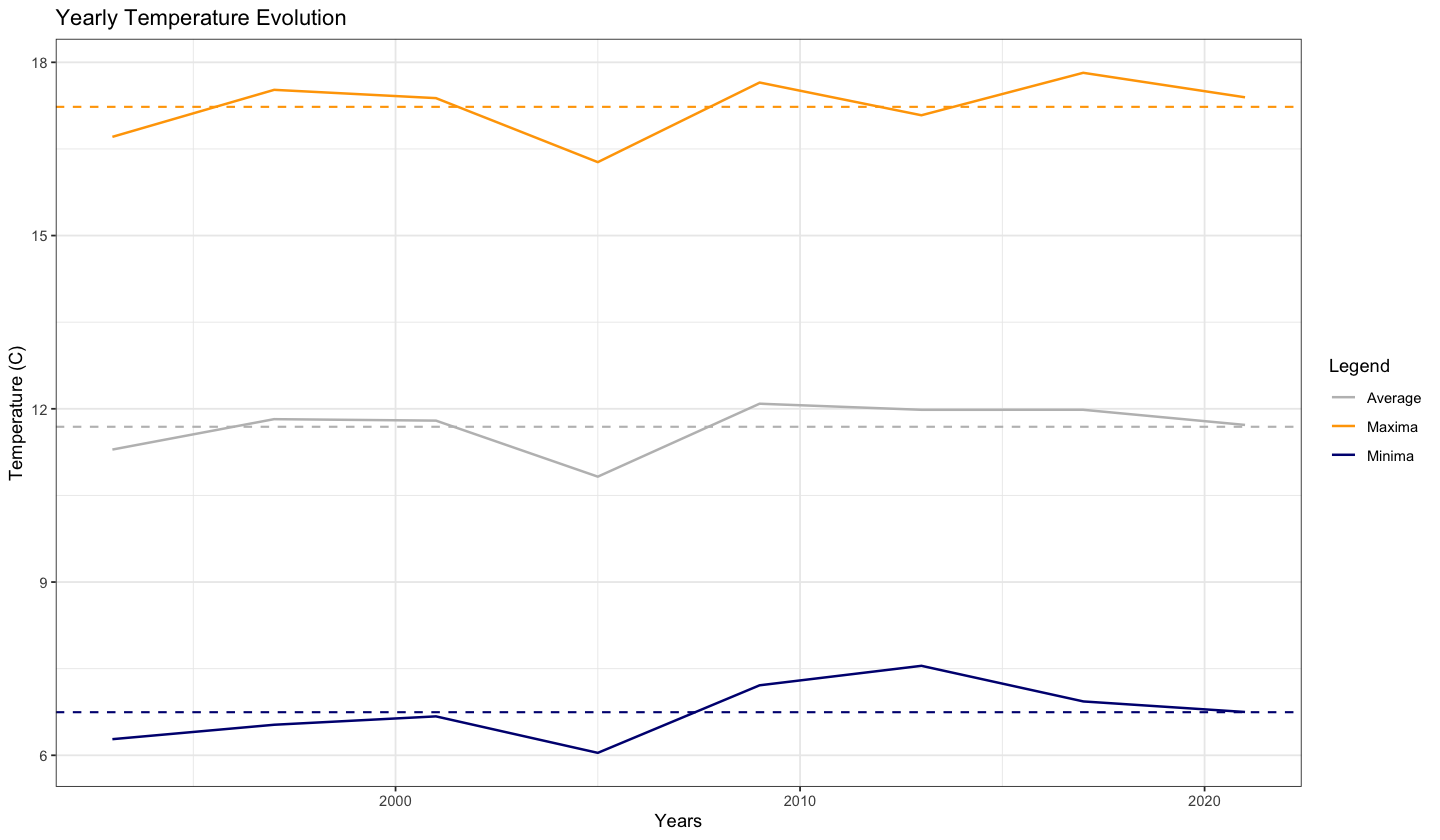

In [16]:
filtered <- yearly_dataset %>%
  filter((year_only - min(year_only))%% 4 == 0) |> mutate(x_fit = 1:length(year_only))

# Visualizziamo il dataframe filtrato
(filtered)

p_y <- ggplot(data = filtered) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Evolution',
       x = 'Years',
       y = 'Temperature (C)') +
  theme_bw()
p_y


In [17]:
lin_chain <- regression(filtered, lin_model_file, lin_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 24
   Unobserved stochastic nodes: 9
   Total graph size: 102

Initializing model



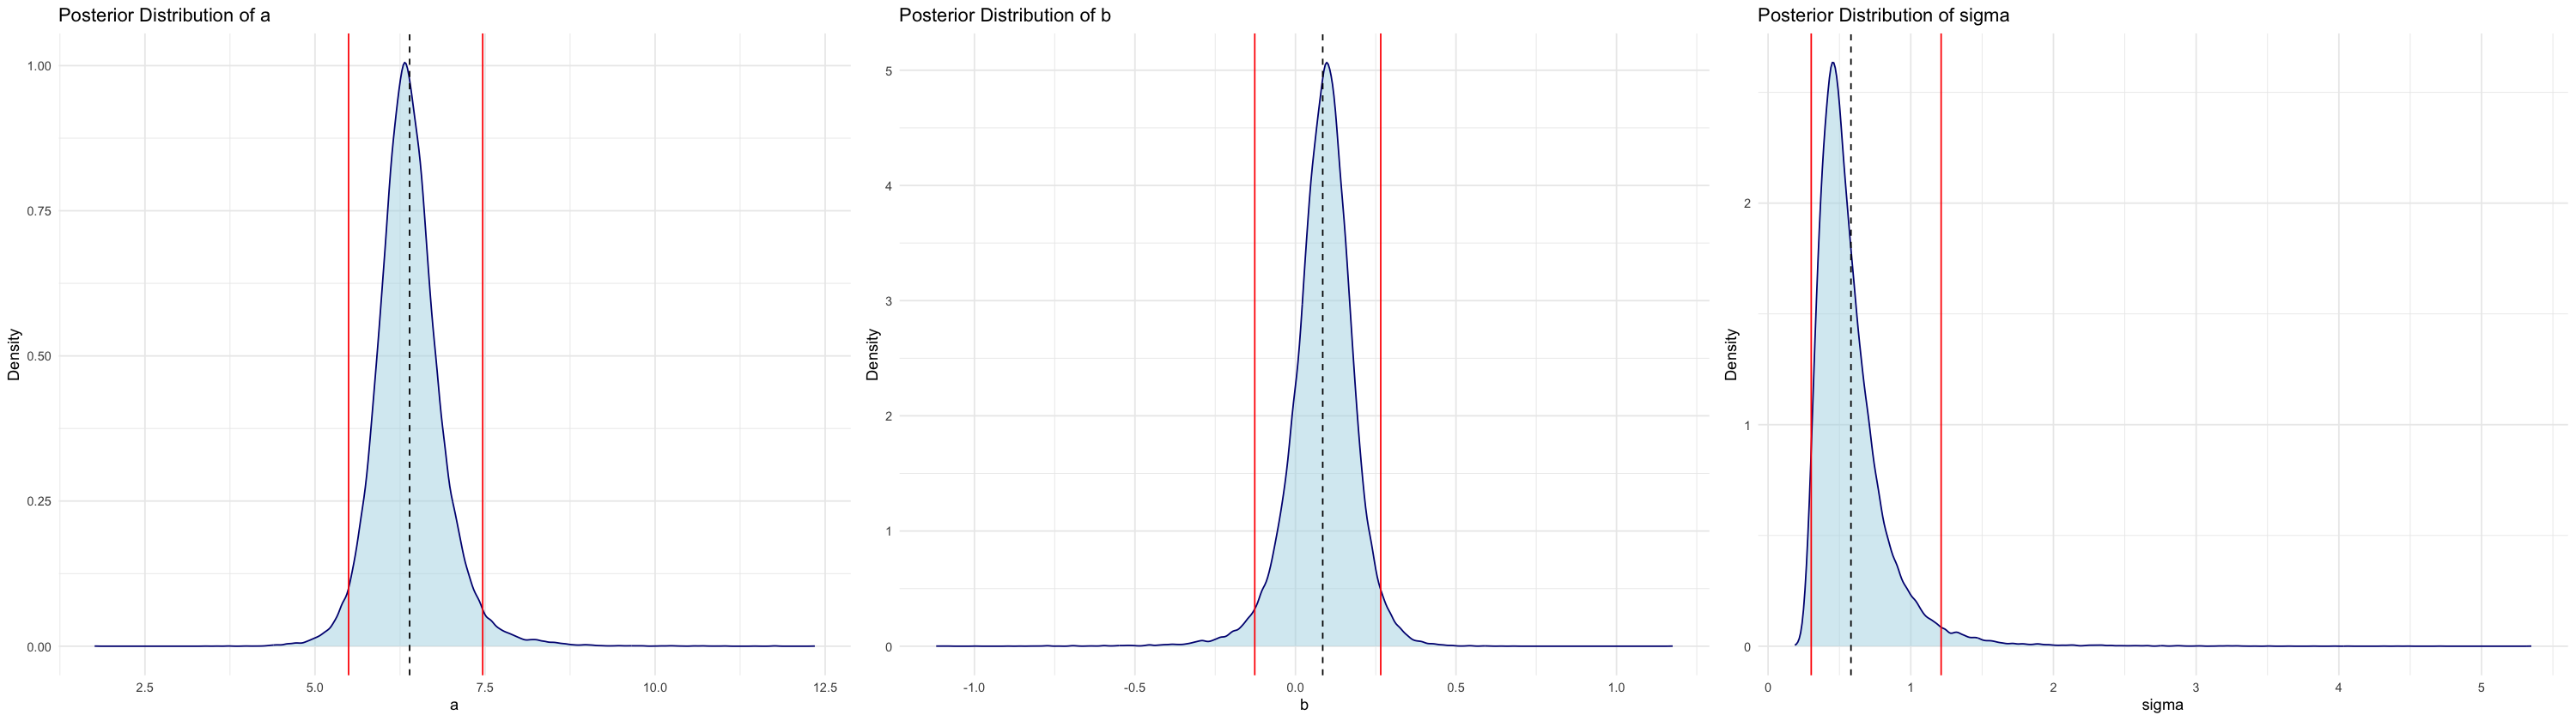

In [18]:
density_plot(lin_chain, 'linear', 'min')

### comparing snpa and our regression
http://www.math.nagoya-u.ac.jp/~richard/teaching/s2021/SML_Guozhang6.pdf



We want now to compare the values we infer from the montecarlo process with the one obtained in snpa document so our hypotesis test is set as:


$\left\{\begin{array}{rl}
H_0 : b' \in [\mu_{snpa} - k, \mu_{snpa} + k]\\
H_0 : b' \not\in [\mu_{snpa} - k, \mu_{snpa} + k]
\end{array}
\right.$

with $k$ half of the confidential interval. If now we rescale the distribution of b we can obtain $b' \sim N(\mu', \sigma') : \mu' = \frac{10}{4}\mu_b , \sigma' = \frac{10}{4}\sigma_b$ so now 

$P(H_0 | \mu_{snpa}, k, b') = P(b' \in [\mu_{snpa} - k, \mu_{snpa} + k]) = \int_{\mu_{snpa} - k}^{\mu_{snpa} + k} p(b') db'$

p value : 0.15
We can't refuse H_0

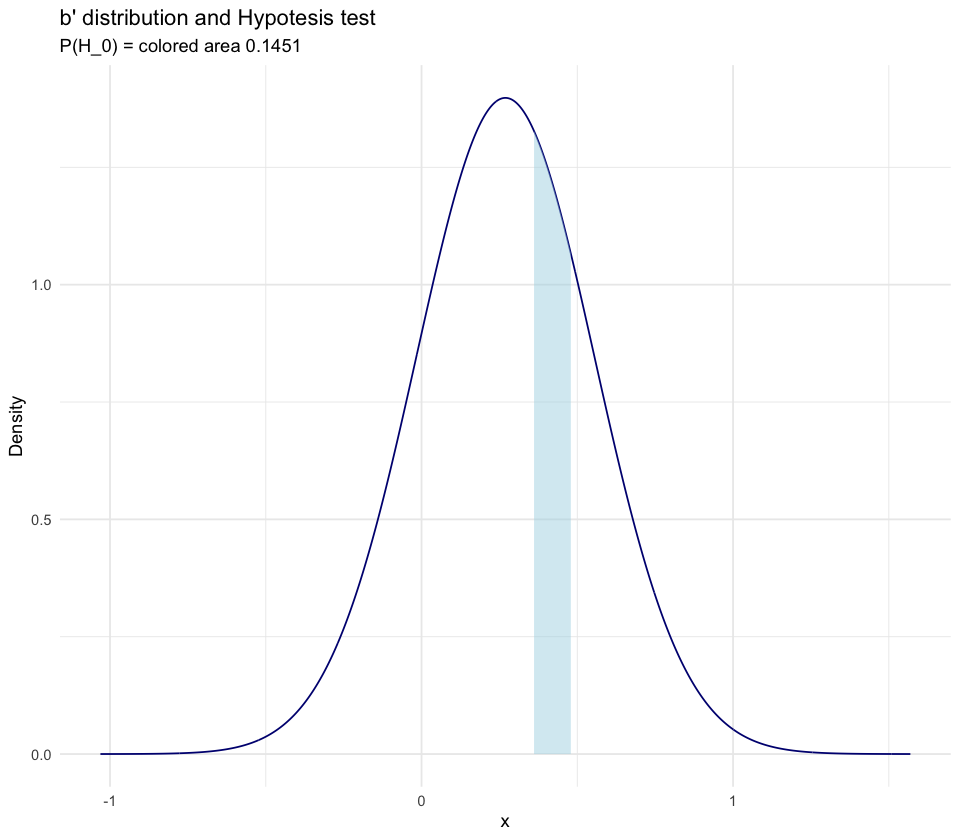

p value : 0.11
We can't refuse H_0

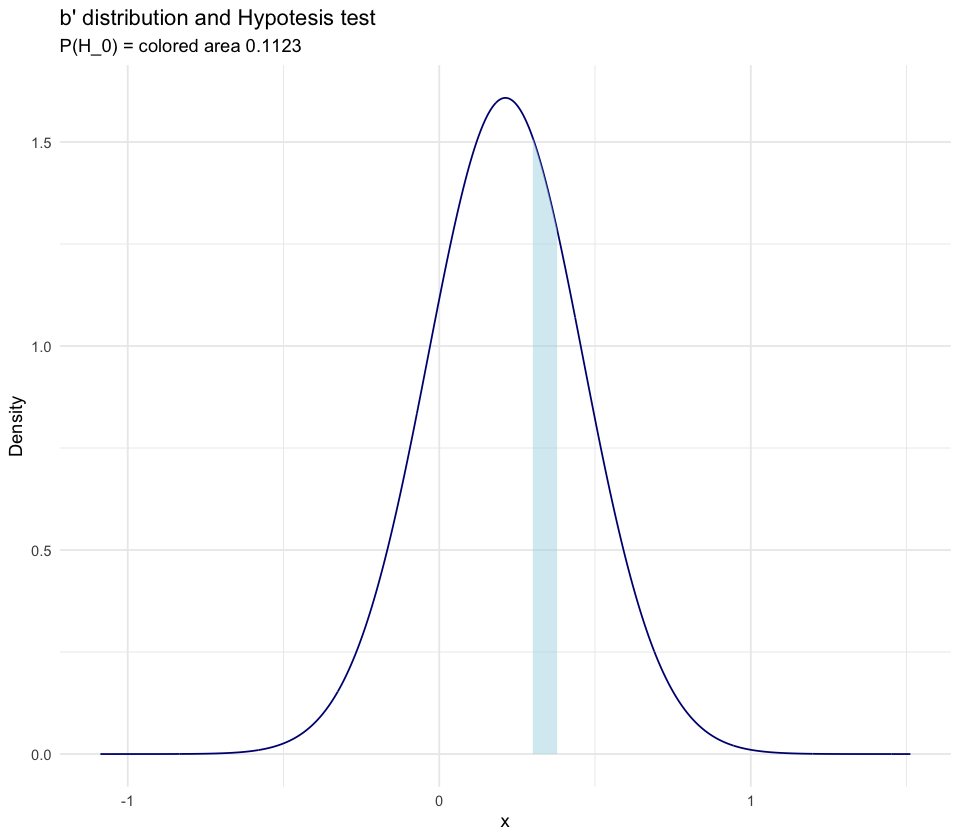

p value : 0.11
We can't refuse H_0

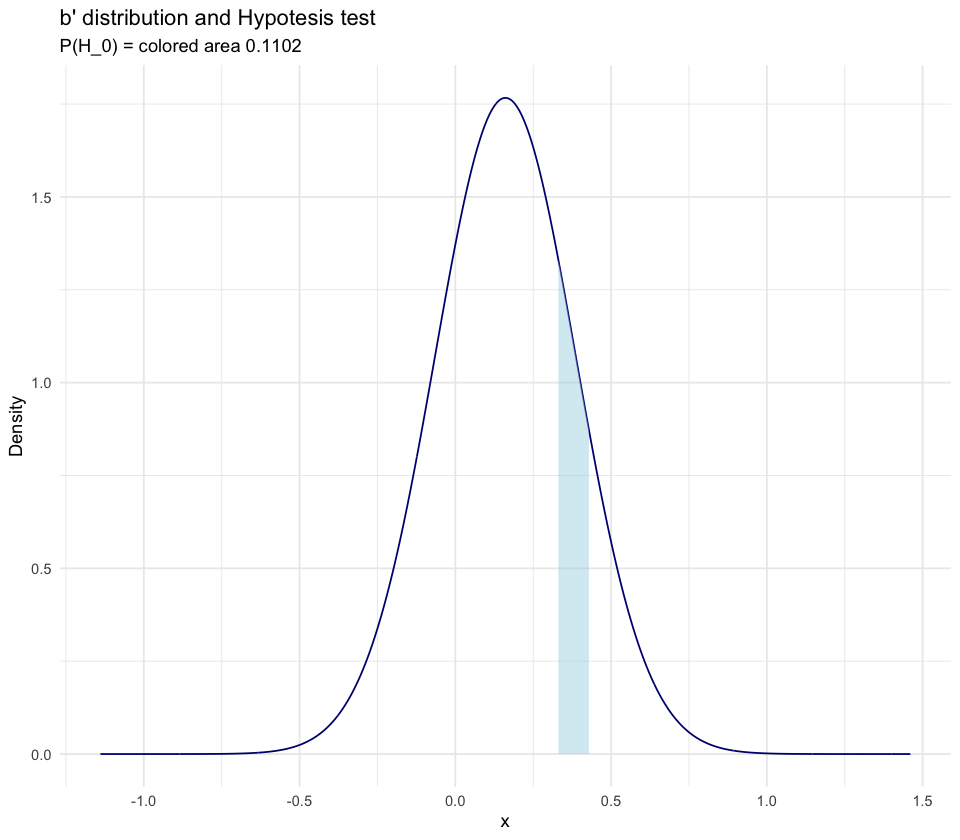

In [20]:
snpa_htest <- function(chain, temp){

    if(temp == 'max'){
        snpa <- list( mu = 0.42, k = 0.06 )
    }
    if(temp == 'ava'){
        snpa <- list( mu = 0.38, k = 0.05 )
    }
    if(temp == 'min'){
        snpa <- list( mu = 0.34, k = 0.04 )
    }

    b_prime_param <- get_model_parameters(chain ,type = 'linear',temp)
    b_prime_mu <- 2.5*b_prime_param[['b']]
    b_prime_sd <- 2.5*b_prime_param[['sd_b']]

    x = seq(b_prime_mu-1.3,b_prime_mu+1.3,0.002)
    b_prime_post <- dnorm(x, b_prime_mu, b_prime_sd)
    test_area <- integrate(dnorm, lower = snpa[['mu']]-snpa[['k']], upper = snpa[['mu']]+snpa[['k']], mean = b_prime_mu, sd = b_prime_sd)$value


    df <- data.frame(x = x, y = b_prime_post)
    options(repr.plot.width = 8, repr.plot.height = 7)
    plot <- ggplot(df, aes(x = x, y = y)) +
        geom_line(color = 'navy') +
        geom_area(data = subset(df, x >= snpa[['mu']]-snpa[['k']] & x <= snpa[['mu']]+snpa[['k']]), aes(x = x, y = y), fill = 'lightblue', alpha = 0.5) +
        labs(title = "b' distribution and Hypotesis test",
             subtitle = paste("P(H_0) = colored area", round(test_area, 4)),
             x = "x",
             y = "Density") +
        theme_minimal()
    print(plot)
        
    chaindf <- as.data.frame( as.mcmc(chain))[['b_min']]
    filtered_b_ava <- chaindf[2*chaindf >= (snpa[['mu']] - snpa[['k']])]
    filtered_b_ava <- filtered_b_ava[2*filtered_b_ava <= (snpa[['mu']] + snpa[['k']])]

        cat('p value :', round(test_area,2))
    if(test_area > 0.05){
        cat('\nWe can\'t refuse H_0')
    }
    else if(test_area <= 0.05){
        cat('\nWe refuse H_0')
    }
}


snpa_htest(lin_chain, temp = 'max')
snpa_htest(lin_chain, temp = 'min')
snpa_htest(lin_chain, temp = 'ava')

In [230]:

ts_data <- diff(yearly_dataset$MIN_mean)

In [236]:
find_best_arima_model <- function(timeseries, iterations) {
    # Divide the series into training and test sets
    
    n_train <- floor(0.75 * length(timeseries))
    training_set <- timeseries[1:n_train] 
    test_set <- timeseries[(n_train + 1):length(timeseries)]  

    # Initialize variables to store the best model
    best_model <- NULL
    best_rmse <- Inf 
    best_aic <- Inf  
    best_params <- NULL
    
    set.seed(123)
    
    # Iterate to find the best ARIMA model
    for (i in 1:iterations) {
        p <- sample(0:5, 1)
        d <- sample(0:3, 1)
        q <- sample(0:4, 1)
        
        model <- Arima(training_set, order = c(p, d, q))
        forecasts <- forecast(model, h = length(test_set))
        
        # Calculate RMSE
        rmse <- sqrt(mean((forecasts$mean - test_set)^2))
        aic <- AIC(model)

        # Update best model if current model is better
        if (rmse < best_rmse || (rmse == best_rmse && aic < best_aic)) {
            best_model <- model
            best_rmse <- rmse
            best_aic <- aic
            best_params <- c(p, d, q)
        }
    }
    
    # Train the best model on the entire dataset
    final_model <- Arima(timeseries, order = best_params)
    
    return(list(best_model = final_model, training = training_set, test = test_set, best_params = best_params))
}

plot_forecasts <- function(model, training_set, test_set) {
    # Forecast on the training set length + future
    forecast_length <- length(test_set)
    total_length <- length(training_set) + forecast_length
    forecasts <- forecast(model, h = forecast_length)
    
    # Create a data frame for ggplot
    time_index <- 1:total_length
    actual_values <- c(training_set, test_set)
    forecast_values <- c(rep(NA, length(training_set)), forecasts$mean)
    lower_conf <- c(rep(NA, length(training_set)), forecasts$lower[,2])
    upper_conf <- c(rep(NA, length(training_set)), forecasts$upper[,2])
    
    df <- data.frame(
        time_index = time_index,
        actual_values = actual_values,
        forecast_values = forecast_values,
        lower_conf = lower_conf,
        upper_conf = upper_conf
    )
    
    # Plot using ggplot2
    ggplot(df, aes(x = time_index)) +
        geom_line(aes(y = actual_values), color = 'blue') +
        geom_line(aes(y = forecast_values), color = 'red') +
        geom_ribbon(aes(ymin = lower_conf, ymax = upper_conf), fill = 'grey80', alpha = 0.5) +
        labs(title = 'Actual vs Forecasted Values', x = 'Time', y = 'Values') +
        theme_minimal()
}

# Example usage
set.seed(123)
timeseries <- ts(rnorm(100, 50, 10), frequency = 12)
result <- find_best_arima_model(timeseries, 100)
plot_forecasts(result$best_model, result$training_set, result$test_set)

In [239]:
model <- find_best_arima_model(ts_data,iterations = 300)$best_model
summary(model)

ERROR: Error in eval(expr, envir, enclos): oggetto 'timeseries' non trovato


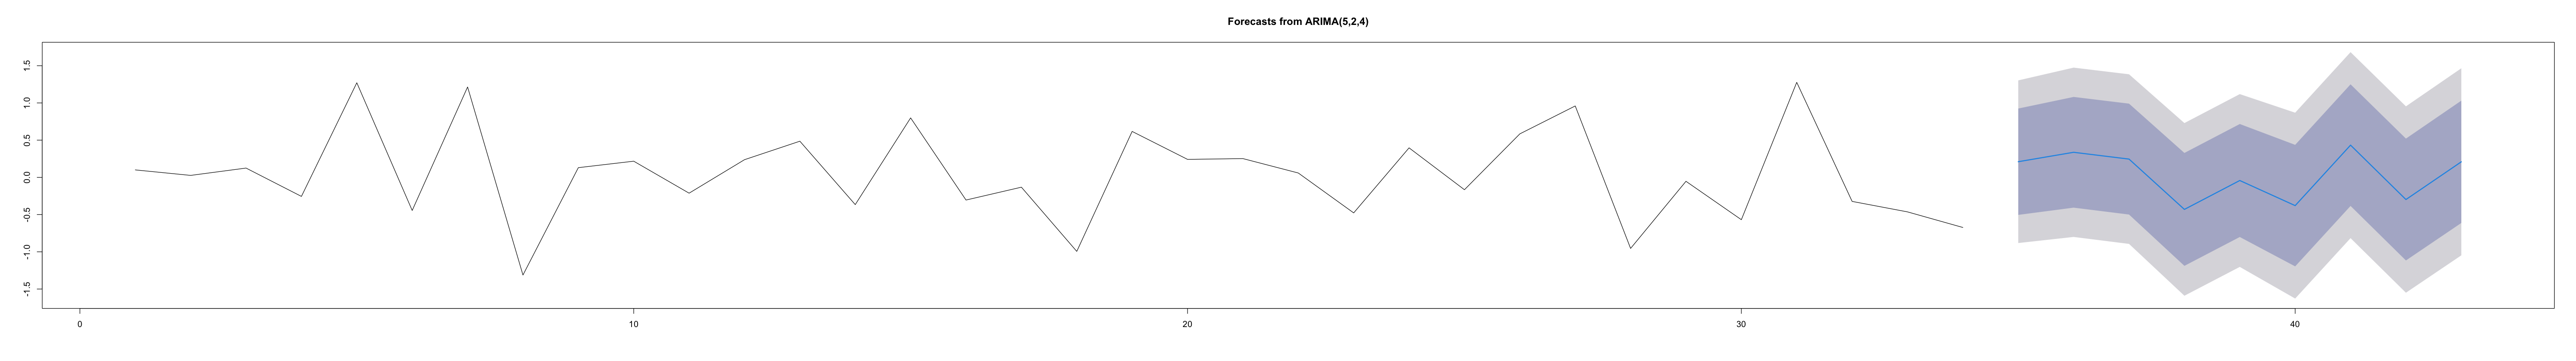

In [238]:
forecast <- forecast(object = model,h = 9)
plot(forecast)

In [127]:
mean(forecasts_best_arima[[4]] - ts_data[1:5])

[1] 1.526

In [121]:
summary(forecasts_best_arima)


Forecast method: ARIMA(0,1,3)

Model Information:
Series: timeseries 
ARIMA(0,1,3) 
Box Cox transformation: lambda= -0.3799866 

Coefficients:
          ma1     ma2      ma3
      -0.3422  0.1427  -0.3947
s.e.   0.1691  0.1457   0.1844

sigma^2 = 0.00146:  log likelihood = 64.01
AIC=-120.02   AICc=-118.64   BIC=-113.91

Error measures:
                    ME      RMSE      MAE      MPE     MAPE      MASE      ACF1
Training set 0.1312902 0.5184068 0.384325 1.650172 5.440161 0.7828047 -0.138318

Forecasts:
   Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
36       6.830265 6.182054 7.576140 5.872946 8.017012
37       6.991486 6.201216 7.927756 5.832204 8.494435
38       7.189562 6.218297 8.383270 5.776446 9.127887
39       7.189562 6.184239 8.435121 5.729483 9.217287
40       7.189562 6.151655 8.485517 5.684715 9.304604